# Estimating the Increase in Digital Library Checkouts in Seattle Due to The Covid-19 Pandemic

Carol Phillips Hatter

July 22, 2020

During the last few months as I have spent much more time at home along with everyone else, I have been spending more time reading and listening to audioboks. I'm curious if others have been doing the same, and if this would be a trend I could observe in Seattle Public Library checkout data. The physical branches have been closed since March 25, but digital checkouts for ebooks and audiobooks are still available. I want to see if there has been an increase in digital checkouts since the pandemic began, and if the increase can offset the decrease in physical checkouts due to branch closures.

I used the [Checkouts By Title](https://data.seattle.gov/Community/Checkouts-by-Title/tmmm-ytt6) dataset from data.seattle.gov to perform this analysis. The dataset has monthly checkout totals by title, type (audiobook, ebook, book, music, etc.) and usage class (physical/digital)

I found that digital checkouts only increased about 13% in April, May and June, for a total of 147,500 incremental digital checkouts. This does not come close to offsetting the decrease in physical checkouts which is about 1,050,000 for the same time period.

In [1]:
import os
os.chdir('..')

import pandas as pd
import numpy as np
import  altair as alt
import statsmodels.api as sm
import datetime as dt
import bookworm.data
alt.renderers.enable('mimetype')
pd.options.mode.chained_assignment = None

# Pull Data

In [2]:
df = bookworm.data.get_checkouts_by_usage_class()

Loading cached data...
Processing data...
Done


In [3]:
df.head()

,month_date,usage_class,monthly_checkouts
58,2017-01-01,Digital,185376
36,2017-01-01,Physical,331830
31,2017-02-01,Digital,168370
66,2017-02-01,Physical,299992
56,2017-03-01,Digital,186795


# Digital vs Physical Trends

Between January 2017 and March 2020, Digital checkouts grew linearly each month while Physical checkouts stayed approximately constant with some month-to-month variation. After March 2020, Physical checkouts dropped to zero due to branch closures, and Digital checkouts seemed to increase beyond the expected trend. Visually, I can see that the digital checkouts increase does not offset the decrease in physical checkouts. However, I still want to know how much digital checkouts grew beyond what we would have expected during the pandemic.

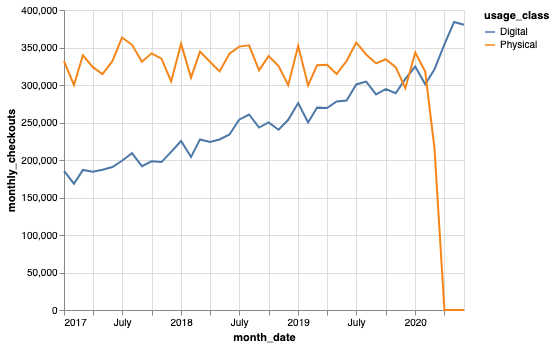

In [4]:
alt.Chart(df).mark_line().encode(
    x='month_date',
    y='monthly_checkouts',
    color='usage_class'
)

# Modeling Pre-Covid Digital Checkouts Trend

To determine the causal impact of the pandemic on digital book checkouts, I can see if a linear model fits the trend prior to March. If it fits well, I can use the linear model to estimate what the digital checkouts would have been without the pandemic, and calculate the difference between the estimate and the actual digital checkouts.

In [5]:
digital = df.query("usage_class == 'Digital'")

In [6]:
digital.head()

,month_date,usage_class,monthly_checkouts
58,2017-01-01,Digital,185376
31,2017-02-01,Digital,168370
56,2017-03-01,Digital,186795
69,2017-04-01,Digital,184500
47,2017-05-01,Digital,187126


## See if a linear model is a good estimator

I can see if a linear model is a good estimator by fitting a line to the monthly digital checkouts for January 2017 through November 2019, and using that model to predict the digital checkout volume for December 2019, January 2020 and February 2020. The error on that holdout set will give me an idea of how accurate a linear model will be when it's fit on all the data through March and used to predict what would have happened in April and May under normal non-pandemic circumstances.

In [7]:
# creates a variable t counting the number of months since the beginning of the dataset, starting at 1
digital.loc[:, 't'] = np.arange(1, len(digital) + 1)

In [8]:
pre = digital.query("month_date < '2019-12-01'")
post = digital.query("month_date >= '2019-12-01' & month_date < '2020-03-01'")

In [9]:
X_pre = sm.add_constant(pre[['t']])
X_post = sm.add_constant(post[['t']])
y = pre[['monthly_checkouts']]

### Test model summary

The summary of the linear model trained on partial data looks good. R-squared and adjusted R-squared are high, and the predictive variable t has a p-value less than .05 and the coefficient looks reasonable. The p-value on the F-statistic is also below .05

In [10]:
model = sm.OLS(y, X_pre)
fitted_model = model.fit()
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:      monthly_checkouts   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                     543.4
Date:                Wed, 22 Jul 2020   Prob (F-statistic):           4.52e-22
Time:                        11:56:12   Log-Likelihood:                -369.43
No. Observations:                  35   AIC:                             742.9
Df Residuals:                      33   BIC:                             746.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.686e+05   3303.418     51.042      0.0

### Prediction error

The mean absolute percentage error on the predictions is 3.4%, and the highest point estimate absolute percentage error is 5.5%. This seems reasonable to me. If the model did not fit well, we could try adding more variables to the linear model to control for other factors like seasonality, or using a more sophisticated time series forecasting model.

In [11]:
post.loc[:, 'preds'] = fitted_model.predict(X_post)

In [12]:
post.loc[:, 'abs_err'] = np.abs(post.loc[:, 'preds'] - post.loc[:, 'monthly_checkouts'])
post.loc[:, 'abs_pct_err'] = post.loc[:, 'abs_err'] / post.loc[:, 'monthly_checkouts']

In [13]:
post

,month_date,usage_class,monthly_checkouts,t,preds,abs_err,abs_pct_err
29,2019-12-01,Digital,308176,36,302923.796639,5252.203361,0.017043
1,2020-01-01,Digital,324650,37,306654.659944,17995.340056,0.055430
42,2020-02-01,Digital,300871,38,310385.523249,9514.523249,0.031623


In [14]:
post['abs_pct_err'].mean()

0.034698701687710304

# Predict the counterfactual digital checkouts for April, May, June

What would we have expected digital checkouts to be under normal circumstances?

In [15]:
pre = digital.query("month_date < '2020-04-01'")
post = digital.query("month_date >= '2020-04-01'")

In [16]:
X_pre = sm.add_constant(pre[['t']])
X_post = sm.add_constant(post[['t']])
y = pre[['monthly_checkouts']]

### Full model summary

The full model looks great also, with a statistically significant predictor variable, a p-value less than .05 on the F-statistic, and R-squared over .95

In [17]:
model = sm.OLS(y, X_pre)
fitted_model = model.fit()
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:      monthly_checkouts   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     760.9
Date:                Wed, 22 Jul 2020   Prob (F-statistic):           2.82e-26
Time:                        11:56:12   Log-Likelihood:                -412.28
No. Observations:                  39   AIC:                             828.6
Df Residuals:                      37   BIC:                             831.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.677e+05   3163.185     53.023      0.0

### Compute incremental digital checkouts

I can use the model fitted on pre-pandemic data to predict what checkouts should have been in April, May and June without the intervention of the pandemic.

In [18]:
digital.loc[:, 'predicted'] = fitted_model.predict(sm.add_constant(digital[['t']]))
digital.loc[:, 'during_shutdown'] = digital['month_date'] > dt.datetime(year=2020, month=3, day=1)

The trend line for digital checkout groth over time is the straight line in blue, and the data for monthly digital checkouts are the blue dots on the graph. The orange dots are the observed digital checkouts during the library shutodwn in April, May and June. The incremental digital checkouts are the difference between the blue trend line and the orange observed digital checkouts

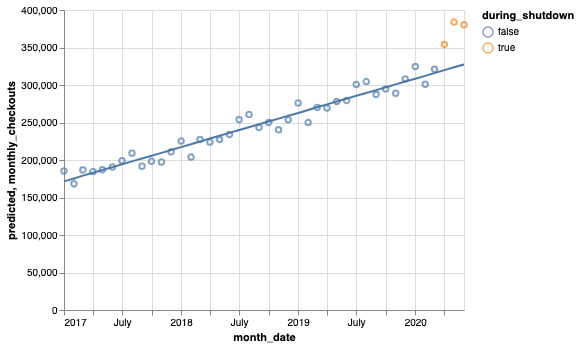

In [19]:
regression_line = alt.Chart(digital).mark_line().encode(
    x='month_date',
    y='predicted'
)

data_points = alt.Chart(digital).mark_point().encode(
    x='month_date',
    y='monthly_checkouts',
    color='during_shutdown'
)

regression_line + data_points

There were about 147,500 incremental digital checkouts total in April, May and June for an average incremental increase in checkouts of 13%. There are typically around 350,000 physical book checkouts each month, so the incremental increase in digital checkouts does not do much to offset the decrease in physical library usage.

In [20]:
preds = fitted_model.predict(X_post)
post.loc[:, 'preds'] = preds
post.loc[:, 'increase'] = post['monthly_checkouts'] - post['preds']
post.loc[:, 'pct_increase'] = post.loc[:, 'increase'] / post.loc[:, 'monthly_checkouts']
post

,month_date,usage_class,monthly_checkouts,t,preds,increase,pct_increase
5,2020-04-01,Digital,354090,40,319800.229420,34289.770580,0.096839
16,2020-05-01,Digital,383934,41,323602.192173,60331.807827,0.157141
49,2020-06-01,Digital,380269,42,327404.154926,52864.845074,0.139020


In [21]:
post['increase'].sum()

147486.4234817808

In [22]:
post['pct_increase'].mean()

0.13099994406619606